In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

from sklearn.datasets import make_regression


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
np.random.seed(42)
X, y = make_regression(n_samples=300, n_features=1, bias=3, n_informative=1, noise=10)
y = y.reshape(-1,1)
X.shape, y.shape

((300, 1), (300, 1))

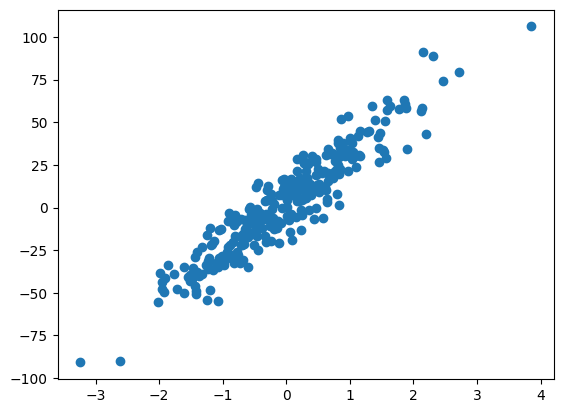

In [4]:
plt.scatter(X,y)

In [5]:
# converting ndarray to torch tensor
X = torch.as_tensor(X, dtype=torch.float)
y = torch.as_tensor(y, dtype=torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

## Creating Dataset from X and y

In [6]:
dataset = TensorDataset(X,y)

## Pytorch random split to split our data to train and test

In [7]:
total_observation = len(X)
N_train = int(0.7 * total_observation) # 70% training
N_val = total_observation -  N_train
train_data, val_data = random_split(dataset, [N_train, N_val])
len(train_data), len(val_data)

(210, 90)

In [8]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)

In [9]:
# creating Linear model

class LinearModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(1,1)

  def forward(self, X):
    return self.fc(X)

In [27]:
def make_train_step_fn(model, loss_fn, optimizer):

  def train(X, y):
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

  return train


def make_val_step_fn(model, loss_fn):

  def validate(X, y):
    model.eval()

    y_pred = model(X)
    loss= loss_fn(y_pred, y)
    return loss.item()

  return validate


def mini_batch_step(device, loader, step_fn):
  mini_batch_losses = []
  for mini_batch_x, mini_batch_y in loader:
    mini_batch_x =  mini_batch_x.to(device)
    mini_batch_y =  mini_batch_y.to(device)

    mini_batch_loss = step_fn(mini_batch_x, mini_batch_y)
    mini_batch_losses.append(mini_batch_loss)
  return np.mean(mini_batch_losses)




In [30]:
epochs = 100
lr = 0.01
model = LinearModel()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train = make_train_step_fn(model, loss_fn, optimizer)
validate = make_val_step_fn(model, loss_fn)

losses = []
val_losses = []

for _ in range(epochs):
  train_loss = mini_batch_step(device, train_loader, train)
  losses.append(train_loss)
  with torch.no_grad():
    val_loss = mini_batch_step(device, val_loader, validate)
    val_losses.append(val_loss)

In [29]:
model.state_dict()

OrderedDict([('fc.weight', tensor([[28.3748]], device='cuda:0')),
             ('fc.bias', tensor([2.5669], device='cuda:0'))])

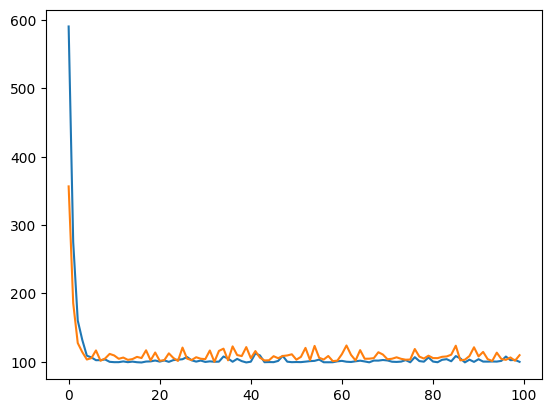

In [36]:
plt.plot(range(100), losses)
plt.plot(range(100), val_losses)
